In [11]:
import cdflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = 'DATA/dmsp-f16_ssj_precipitating-electrons-ions_20100101_v1.1.2.cdf'
cdflib.cdf_to_xarray(path)

<xarray.Dataset>
Dimensions:                    (Epoch: 86400, dim0: 3, CHANNEL_ENERGIES: 19,
                                dim1: 19)
Coordinates:
  * Epoch                      (Epoch) float64 6.343e+13 6.343e+13 ... 6.343e+13
  * CHANNEL_ENERGIES           (CHANNEL_ENERGIES) float32 3e+04 ... 30.0
Dimensions without coordinates: dim0, dim1
Data variables: (12/26)
    SC_ECI                     (Epoch, dim0) float64 5.063e+03 ... 1.544e+03
    SC_ECI_LABEL               (dim0) <U5 'x_ECI' 'y_ECI' 'z_ECI'
    SC_GEOCENTRIC_LAT          (Epoch) float64 -32.11 -32.05 ... 12.28 12.34
    SC_GEOCENTRIC_LON          (Epoch) float64 293.7 293.6 293.6 ... 286.3 286.3
    SC_GEOCENTRIC_R            (Epoch) float64 7.227e+03 7.227e+03 ... 7.225e+03
    SC_AACGM_LAT               (Epoch) float64 -27.86 -27.82 ... 30.13 30.17
    ...                         ...
    ION_DIFF_ENERGY_FLUX       (Epoch, CHANNEL_ENERGIES) float32 0.0 0.0 ... 0.0
    ION_DIFF_ENERGY_FLUX_STD   (Epoch, CHANNEL_ENERGIES) float32 nan nan ... nan
    ION_TOTAL_ENERGY_FLUX      (Epoch) float32 0.0 0.0 ... 0.0 3.46e+07
    ION_TOTAL_ENERGY_FLUX_STD  (Epoch) float32 nan nan 1.449 ... nan nan 1.803
    ION_AVG_ENERGY             (Epoch) float32 nan nan ... nan 1.392e+03
    ION_AVG_ENERGY_STD         (Epoch) float32 nan nan 2.123 ... nan nan 2.55
Attributes: (12/26)
    Project:                     DMSP
    Source_name:                 dmsp-f16
    Discipline:                  ['Space Physics>Magnetospheric Science', 'Sp...
    Data_type:                   precipitating-electrons-ions
    Descriptor:                  ssj
    File_naming_convention:      source_descriptor_datatype_yyyyMMdd
    ...                          ...
    MODS:                        This is version 1, beta.
    LINK_TEXT:                   NGDC Solar & Terrestrial Physics Satellite D...
    LINK_TITLE:                  NGDC STP Satellite Data Services
    HTTP_LINK:                   http://www.ngdc.noaa.gov/stp/satellite/satda...
    DWELL_TIME:                  The count integration time at each energy st...
    VERSION:                      1.1.2

In [3]:
cdf_file = cdflib.CDF(path)
ion = cdf_file['ION_DIFF_ENERGY_FLUX']
ele = cdf_file['ELE_DIFF_ENERGY_FLUX']

In [4]:
from datetime import datetime


a = cdflib.cdfepoch.unixtime(cdf_file['Epoch'])
date = [datetime.utcfromtimestamp(aa) for aa in a]

In [16]:
df = np.array([ion.max(axis=1), ele.max(axis=1)])
df = pd.DataFrame(df.T, columns=['ION', 'ELECTRON'], index=date)

In [17]:
df

,ION,ELECTRON
2010-01-01 00:00:00,0.000000,0.000000e+00
2010-01-01 00:00:01,0.000000,0.000000e+00
2010-01-01 00:00:02,963065.437500,5.105612e+05
2010-01-01 00:00:03,0.000000,0.000000e+00
2010-01-01 00:00:04,0.000000,3.380347e+06
...,...,...
2010-01-01 23:59:55,0.000000,1.313410e+06
2010-01-01 23:59:56,0.000000,7.880457e+05
2010-01-01 23:59:57,0.000000,4.012872e+05
2010-01-01 23:59:58,0.000000,1.546359e+06


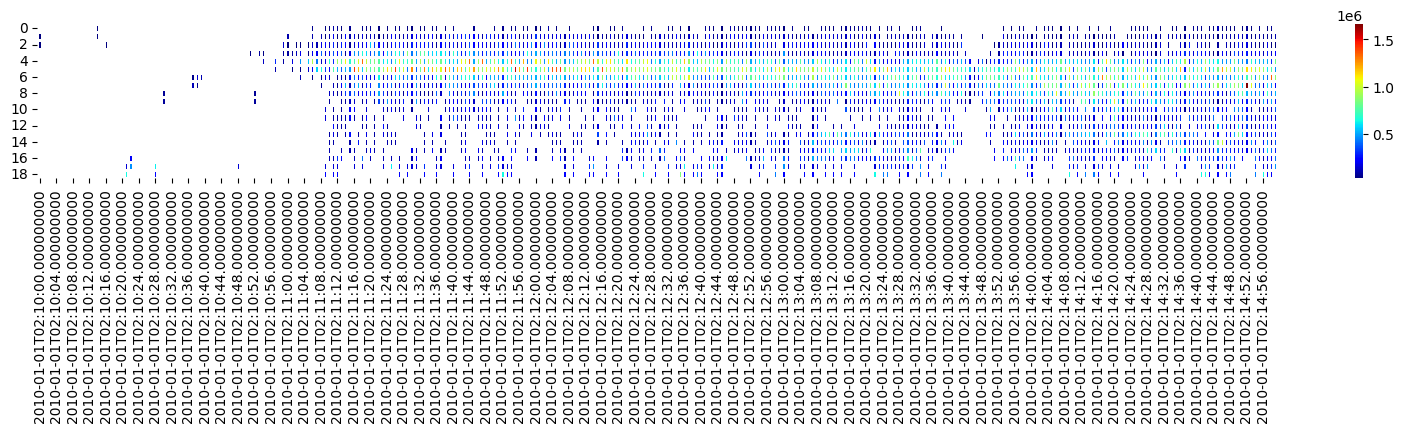

In [7]:
st = 7800
et = st + 300
df_ion = pd.DataFrame(ion.T[:, st:et], columns=date[st:et])
df_ion_mask = (df_ion == 0)
plt.figure(figsize=(20,2))
sns.heatmap(df_ion, linewidths = 1,cmap = "jet", mask = df_ion_mask)
plt.show()

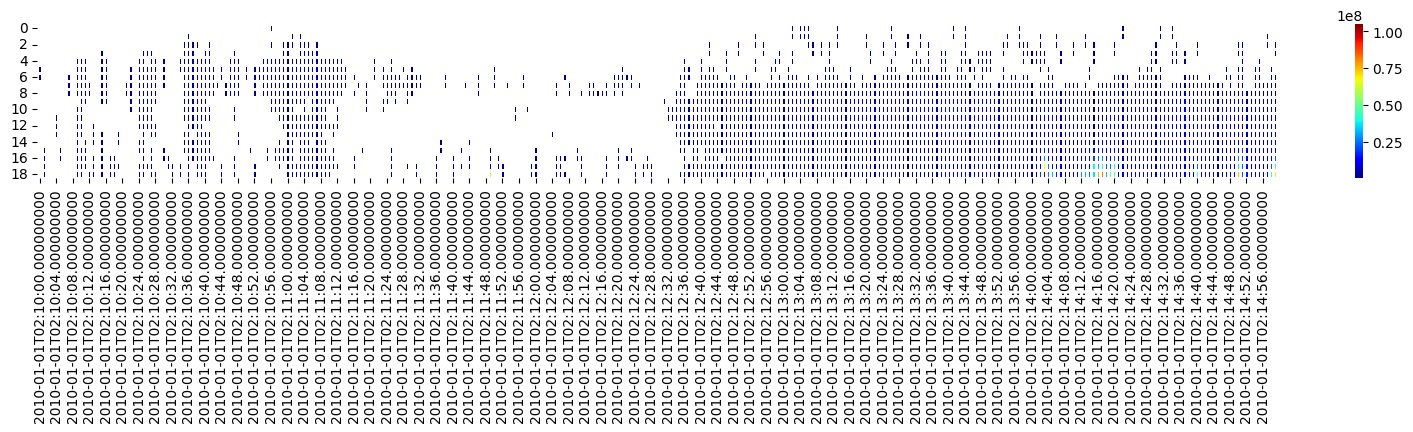

In [20]:
st = 7800
et = st + 300

df_ele = pd.DataFrame(ele.T[:, st:et], columns=date[st:et])
df_ele_mask = (df_ele == 0)
plt.figure(figsize=(20,2))
sns.heatmap(df_ele, linewidths = 1,cmap = "jet", mask = df_ele_mask);

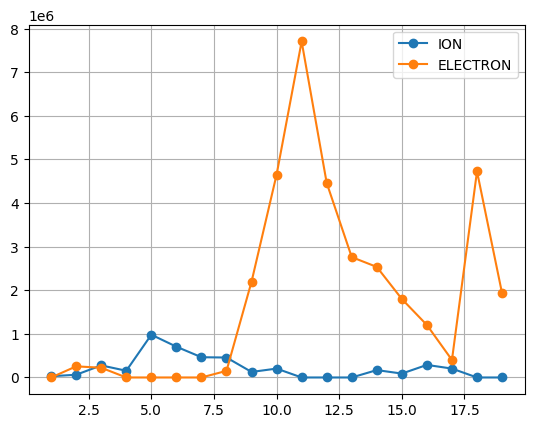

In [21]:
def plot_fig(id, ion, ele):
    plt.plot(list(range(1, 20)), ion[id], marker='o', label='ION')
    plt.plot(list(range(1, 20)), ele[id], marker='o', label='ELECTRON')
    plt.grid()
    plt.legend()

plot_fig(8000, ion, ele)